In [31]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [32]:
u = mda.Universe(
    "../no_phos_0.5/gromacs/step5_1.tpr", "../no_phos_0.5/gromacs/centered.xtc"
)
ag = u.select_atoms("name CA")

In [33]:
ca_poss = []
for ts in tqdm(u.trajectory):
    ca_poss.append(ag.positions)
ca_poss = np.array(ca_poss)

In [34]:
ca_poss.shape

(10001, 549, 3)

In [35]:
ca_poss = ca_poss[::10]

In [36]:
ca_poss.shape

(1001, 549, 3)

## pca 2 component

In [37]:
pca = PCA(n_components=2)

In [38]:
principal_components = pca.fit_transform(ca_poss.reshape((ca_poss.shape[0], 549 * 3)))

In [39]:
principal_components.shape

(1001, 2)

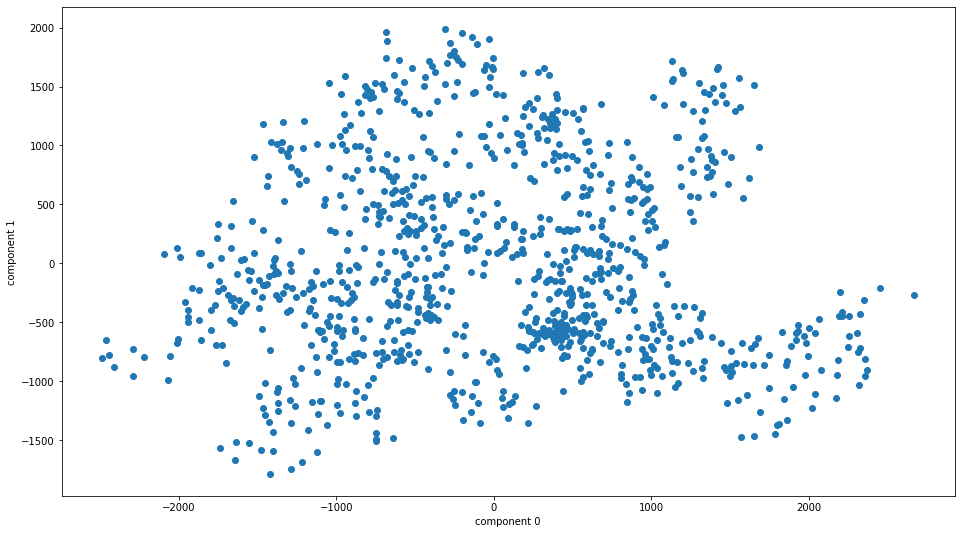

In [40]:
%matplotlib inline
plt.figure(figsize=(16, 9))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel("component 0")
plt.ylabel("component 1");

In [41]:
pca.explained_variance_ratio_

array([0.48535517, 0.32633647], dtype=float32)

## TSNE 2 component

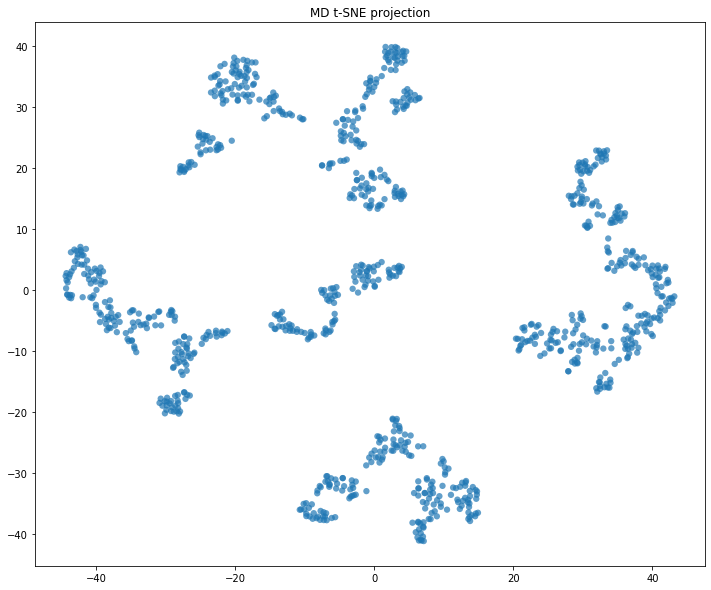

In [42]:
tsne = TSNE(random_state=17, n_components=2)

projected_tsne = tsne.fit_transform(ca_poss.reshape((ca_poss.shape[0], 549 * 3)))

%matplotlib inline

plt.figure(figsize=(12, 10))
plt.title("MD t-SNE projection")
plt.scatter(
    projected_tsne[:, 0], projected_tsne[:, 1], edgecolor="none", alpha=0.7, s=40
);

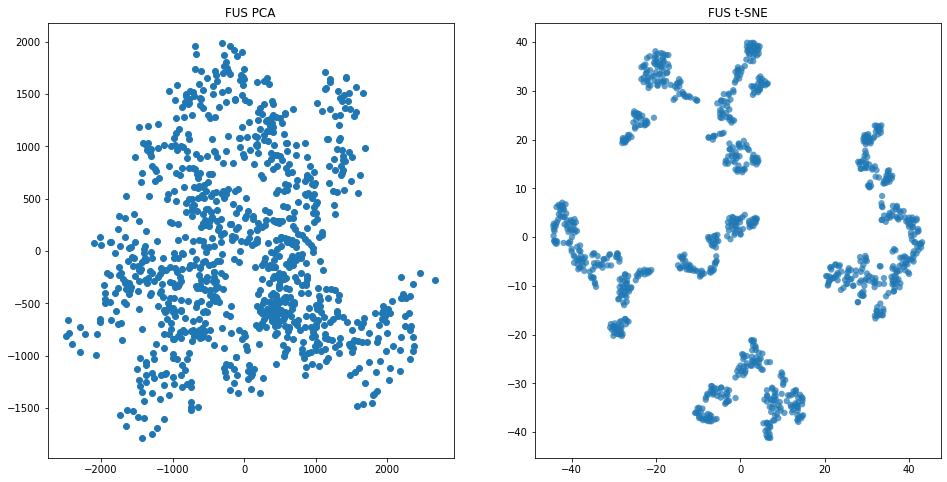

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_title("FUS PCA")
ax[0].scatter(principal_components[:, 0], principal_components[:, 1])

ax[1].set_title("FUS t-SNE")
ax[1].scatter(
    projected_tsne[:, 0], projected_tsne[:, 1], edgecolor="none", alpha=0.7, s=40
);

In [44]:
def out_move_percent(cl):
    n = len(cl)
    on = 0
    for i in range(1, len(cl)):
        if cl[i] != cl[i - 1]:
            on += 1
    return on / n * 100

## 2 component kmean

In [14]:
intertias = []
for i in range(2, 25):
    kmeans = KMeans(n_clusters=i, random_state=0)
    clusters = kmeans.fit_predict(projected_tsne)
    intertias.append(kmeans.inertia_)

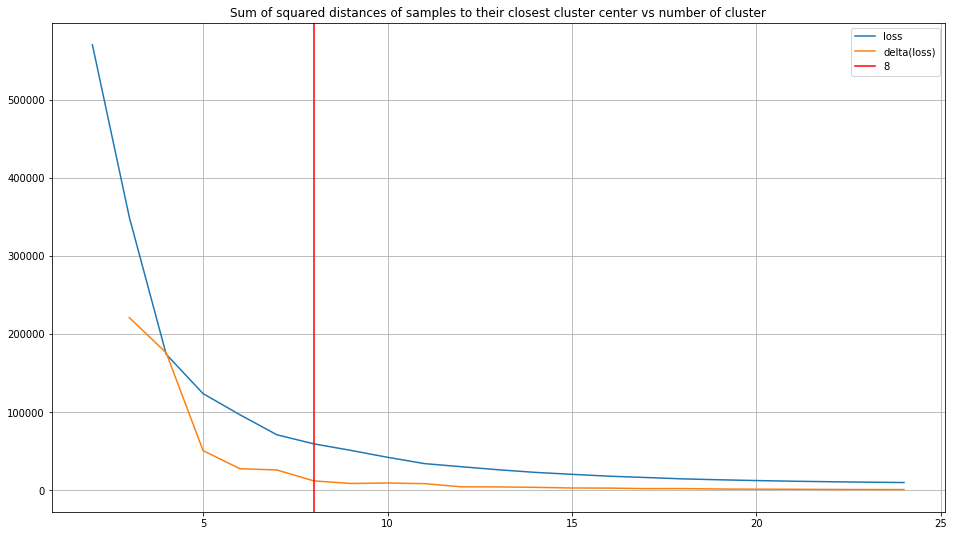

In [15]:
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title(
    "Sum of squared distances of samples to their closest cluster center vs number of cluster"
)
plt.plot(range(2, 25), intertias, label="loss")
plt.plot(range(3, 25), -np.diff(intertias), label="delta(loss)")
plt.axvline(8, label="8", c="r")
plt.grid()
plt.legend();

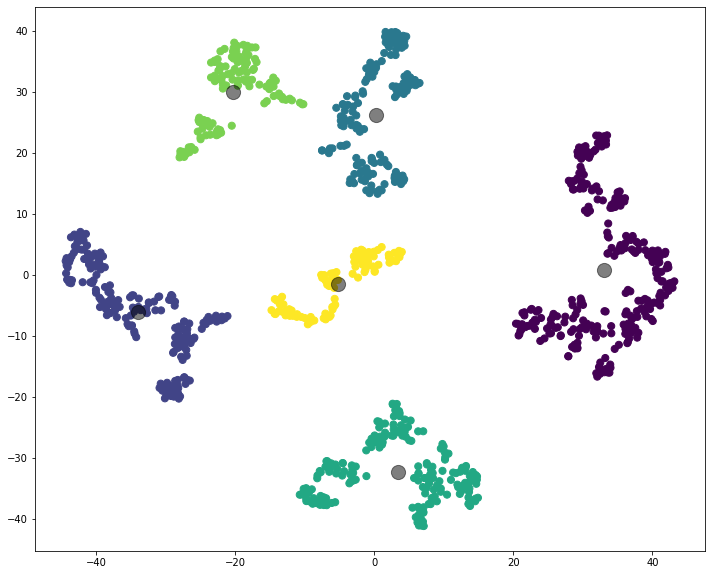

In [45]:
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit_predict(projected_tsne)

%matplotlib inline

fig = plt.figure(figsize=(12, 10))
plt.scatter(
    projected_tsne[:, 0], projected_tsne[:, 1], c=clusters, s=50, cmap="viridis"
)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5);

In [46]:
out_move_percent(clusters)

0.6993006993006993

## 2 component gmm

In [17]:
bics = []
aics = []
losses = []
for i in tqdm(range(2, 40)):
    model = GaussianMixture(n_components=i, random_state=0)
    clusters = model.fit_predict(projected_tsne)
    bics.append(model.bic(projected_tsne))
    aics.append(model.aic(projected_tsne))
    losses.append(model.score(projected_tsne))

Text(0, 0.5, 'Score')

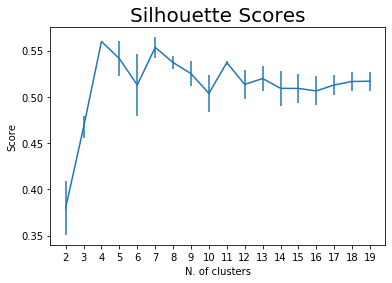

In [52]:
from sklearn import metrics


def SelBest(arr: list, X: int) -> list:
    """
    returns the set of X configurations with shorter distance
    """
    dx = np.argsort(arr)[:X]
    return arr[dx]


n_clusters = np.arange(2, 20)
sils = []
sils_err = []
iterations = 20
for n in n_clusters:
    tmp_sil = []
    for _ in range(iterations):
        gmm = GaussianMixture(n, n_init=2).fit(projected_tsne)
        labels = gmm.predict(projected_tsne)
        sil = metrics.silhouette_score(projected_tsne, labels, metric="euclidean")
        tmp_sil.append(sil)
    val = np.mean(SelBest(np.array(tmp_sil), int(iterations / 5)))
    err = np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

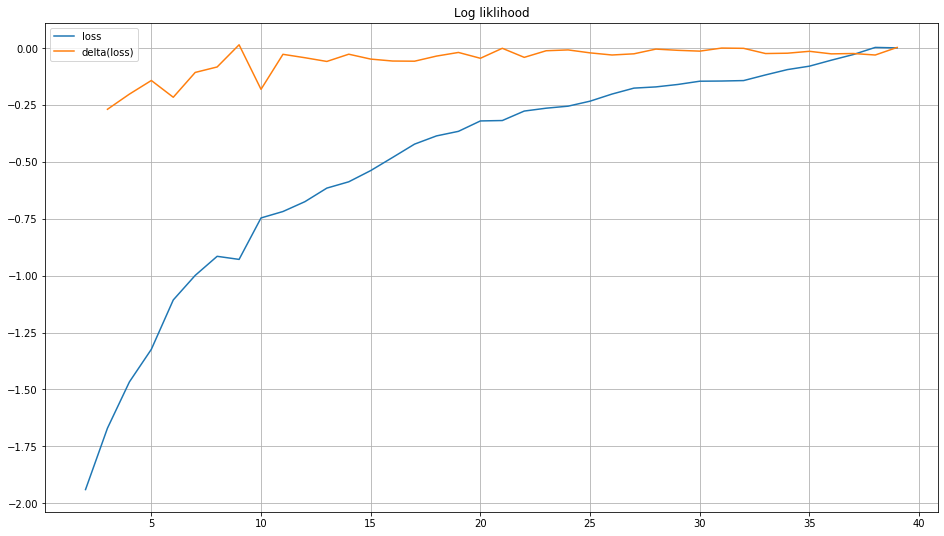

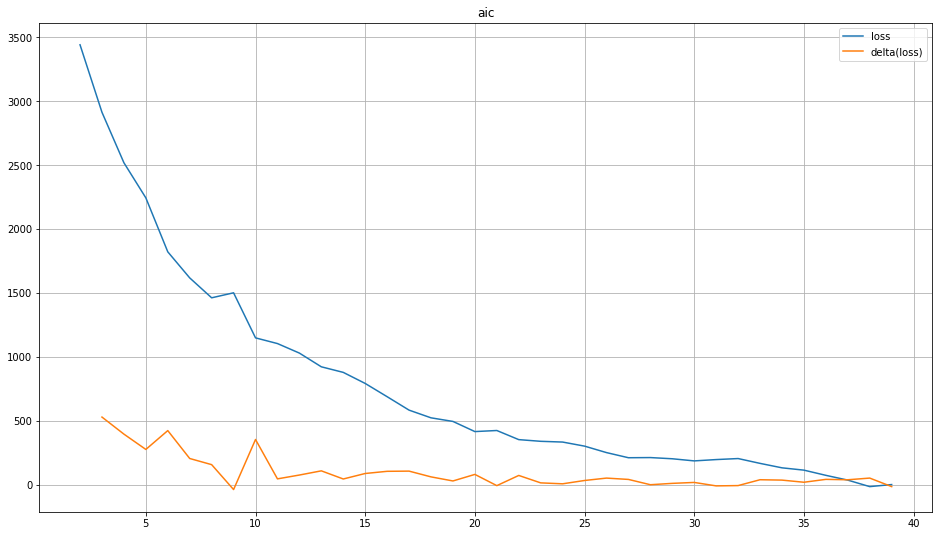

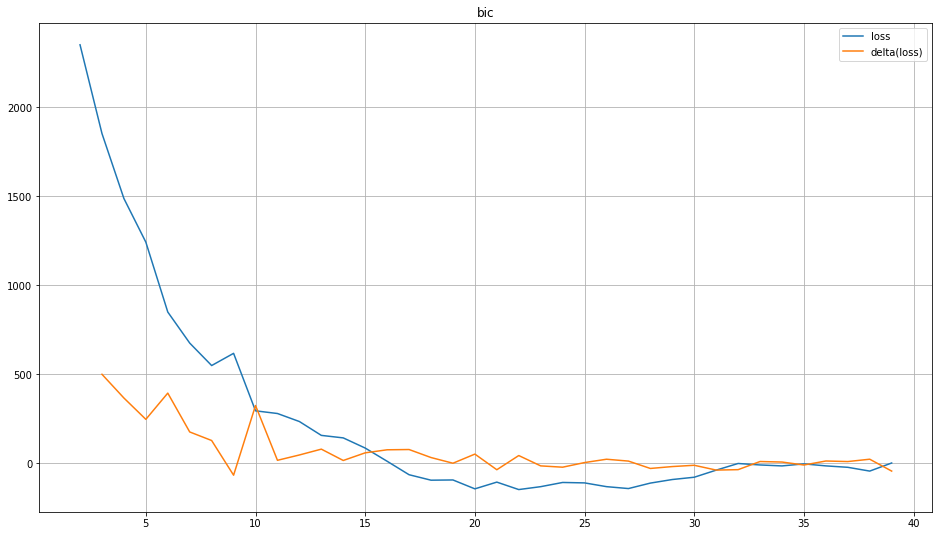

In [51]:
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title("Log liklihood")
plt.plot(range(2, 40), losses - losses[-1], label="loss")
plt.plot(range(3, 40), -np.diff(losses), label="delta(loss)")
plt.grid()
plt.legend()
plt.figure(figsize=(16, 9))
plt.title("aic")
plt.plot(range(2, 40), aics - aics[-1], label="loss")
plt.plot(range(3, 40), -np.diff(aics), label="delta(loss)")
plt.grid()
plt.legend()
plt.figure(figsize=(16, 9))
plt.title("bic")
plt.plot(range(2, 40), bics - bics[-1], label="loss")
plt.plot(range(3, 40), -np.diff(bics), label="delta(loss)")
plt.grid()
plt.legend();

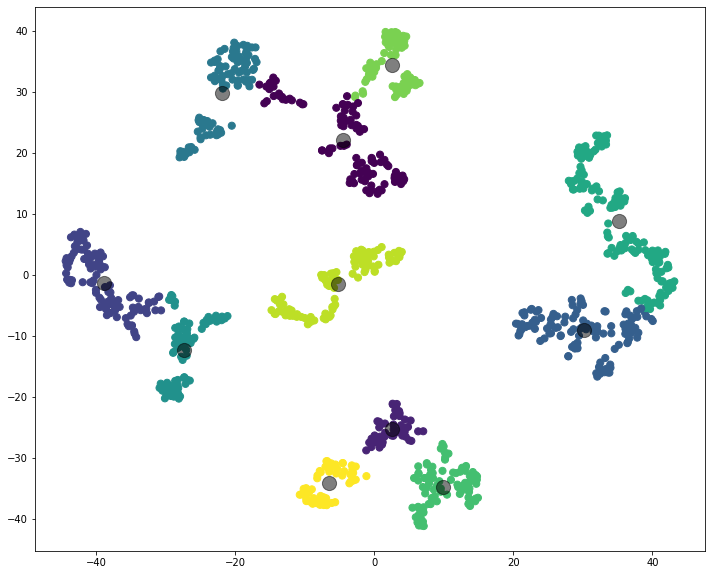

In [50]:
model = GaussianMixture(n_components=11, random_state=0)
clusters = model.fit_predict(projected_tsne)

%matplotlib inline

fig = plt.figure(figsize=(12, 10))
plt.scatter(
    projected_tsne[:, 0], projected_tsne[:, 1], c=clusters, s=50, cmap="viridis"
)
centers = model.means_
plt.scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5);

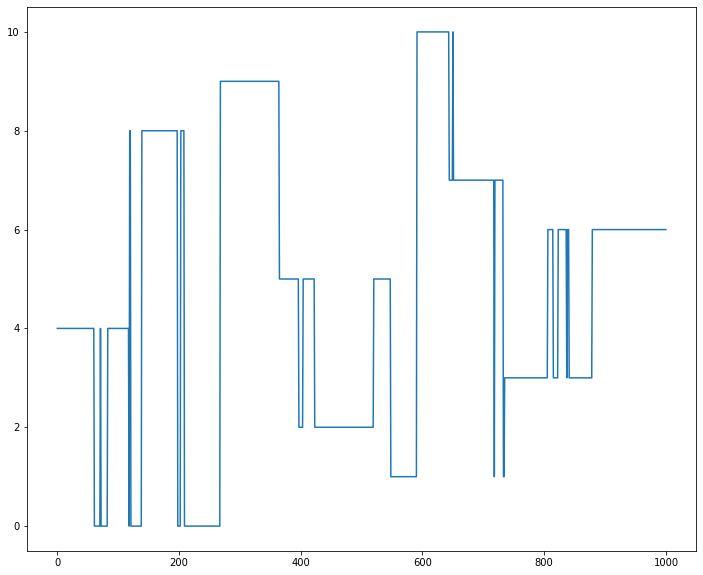

In [53]:
fig = plt.figure(figsize=(12, 10))
plt.plot(clusters);

In [48]:
out_move_percent(clusters)

3.296703296703297

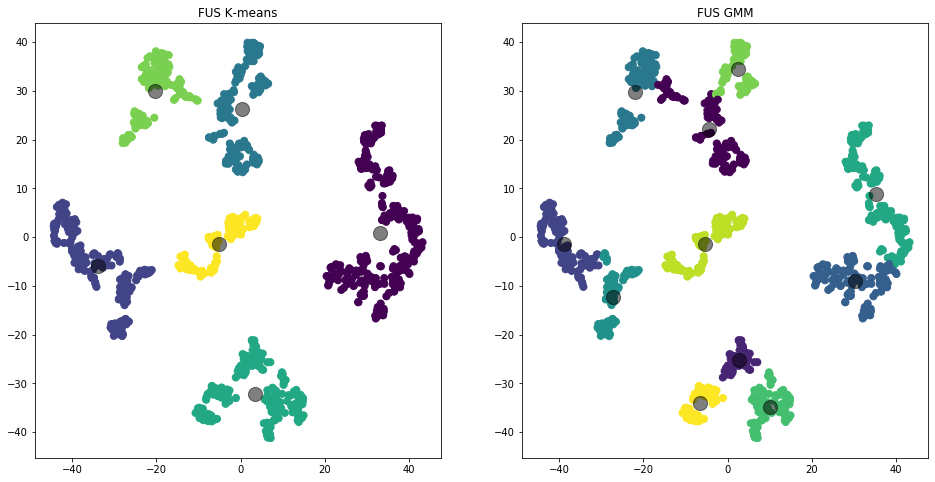

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].set_title("FUS K-means")

clusters = kmeans.fit_predict(projected_tsne)


ax[0].scatter(
    projected_tsne[:, 0], projected_tsne[:, 1], c=clusters, s=50, cmap="viridis"
)
centers = kmeans.cluster_centers_
ax[0].scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5)
ax[1].set_title("FUS GMM")

clusters = model.fit_predict(projected_tsne)

ax[1].scatter(
    projected_tsne[:, 0], projected_tsne[:, 1], c=clusters, s=50, cmap="viridis"
)
centers = model.means_
ax[1].scatter(centers[:, 0], centers[:, 1], c="black", s=200, alpha=0.5);

## pca 3 component

In [21]:
pca = PCA(n_components=3)

In [22]:
principal_components = pca.fit_transform(ca_poss.reshape((ca_poss.shape[0], 549 * 3)))

In [23]:
principal_components.shape

(1001, 3)

<IPython.core.display.Javascript object>


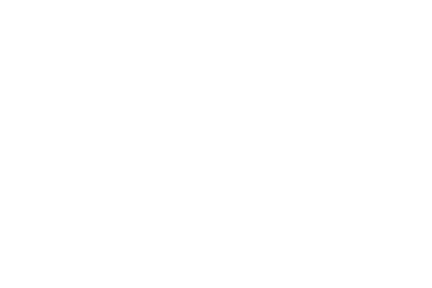

<IPython.core.display.Javascript object>


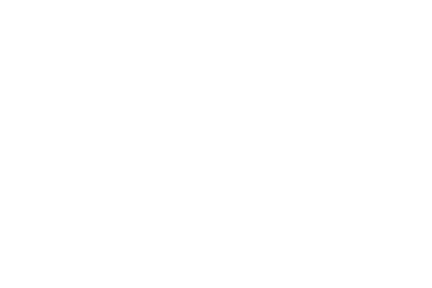

In [24]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    principal_components[:800, 0],
    principal_components[:800, 1],
    principal_components[:800, 2],
)
plt.xlabel("component 0")
plt.ylabel("component 1")
plt.ylabel("component 2");

In [25]:
pca.explained_variance_ratio_

array([0.48535573, 0.32633683, 0.12284612], dtype=float32)

## TSNE 3 component

<IPython.core.display.Javascript object>


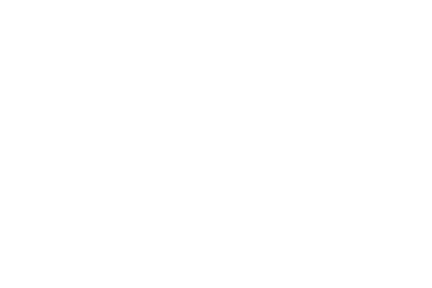

<IPython.core.display.Javascript object>


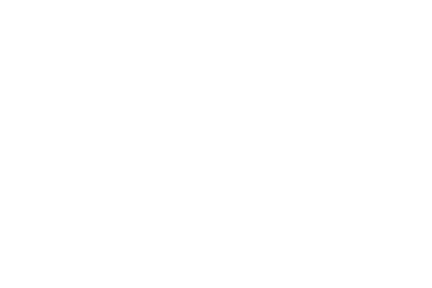

In [26]:
tsne = TSNE(random_state=17, n_components=3)

projected_tsne = tsne.fit_transform(ca_poss.reshape((ca_poss.shape[0], 549 * 3)))

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
ax.scatter(projected_tsne[:, 0], projected_tsne[:, 1], projected_tsne[:, 2])
plt.xlabel("component 0")
plt.ylabel("component 1")
plt.ylabel("component 2");

In [27]:
intertias = []
for i in range(2, 25):
    kmeans = KMeans(n_clusters=i, random_state=0)
    clusters = kmeans.fit_predict(projected_tsne)
    intertias.append(kmeans.inertia_)

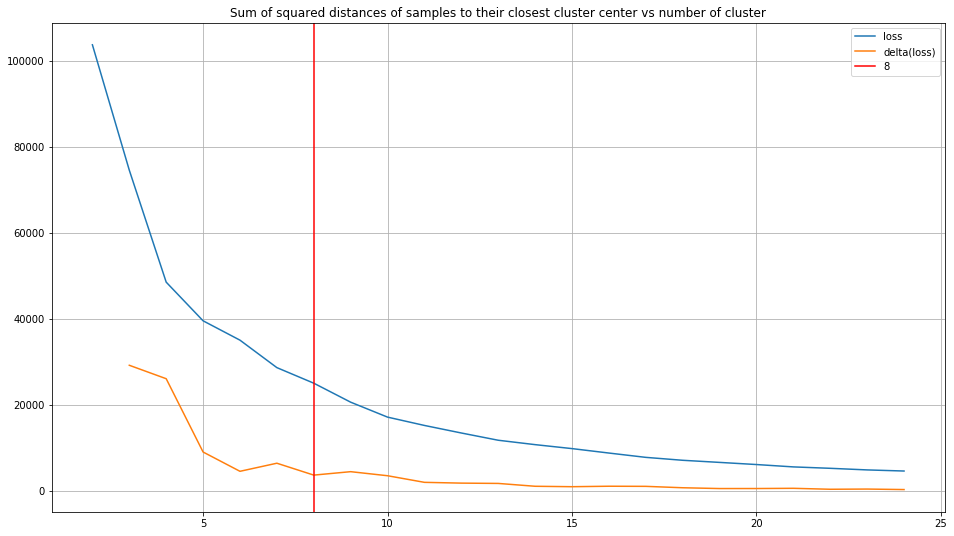

In [28]:
%matplotlib inline

plt.figure(figsize=(16, 9))
plt.title(
    "Sum of squared distances of samples to their closest cluster center vs number of cluster"
)
plt.plot(range(2, 25), intertias, label="loss")
plt.plot(range(3, 25), -np.diff(intertias), label="delta(loss)")
plt.axvline(8, label="8", c="r")
plt.grid()
plt.legend();

<IPython.core.display.Javascript object>


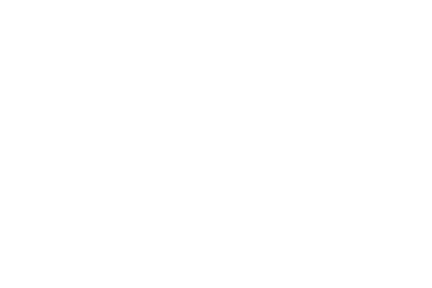

<IPython.core.display.Javascript object>


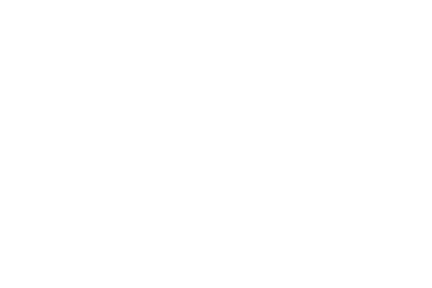

In [29]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(projected_tsne)
kmeans.cluster_centers_.shape

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    projected_tsne[:, 0],
    projected_tsne[:, 1],
    projected_tsne[:, 2],
    c=clusters,
    s=50,
    cmap="viridis",
)
centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c="black", s=200, alpha=0.5);